# Explainable Gaussian Mixture Outlier Detection

The idea is to fit a GMM on synthetically generated data for outlier detection. To keep it simple and beeing able to visualize it, only two dimensions are used. Here three different data structures are beeing evaluted:
- Single Multidimensional Normal Distribution
- Multiple Clusters
- Multiple Multidimensional Normal Distributions

Afterwards the the learned representation of the data shall be used to derive a explanation why a certain point is scored as an outler and which dimension may caused this. Here the following approach is evaluated:
- Mahalanobis Distance per Dimension to each learned Component

In [1]:
# imports
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Ellipse
import scipy
from scipy.special import logsumexp
from scipy.spatial import distance
import math
import matplotlib.patches as mpatches


sns.set_style('darkgrid')

#SEED for reproducability
SEED = 42

np.random.seed(SEED)

# Colors for each GMM Component
COLORS = ["g", "r", "b", "y"]

## Utils

In [2]:
def draw_ellipse(position, covariance, ax=None, nr_patches=4, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 5 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    
    # Draw the Ellipse
    for nsig in range(1, nr_patches):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    """Plots the learned components of a fitted GMM and colors the data points by the predicted labels"""
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.show()

## Single Multidimensional Normal Distribution

### Generate Synthetic Data
This creates synthetic data based on a two dimensional normal distribution and introduces outliers in x, y or in both dimensions.

In [3]:
samples_size = 500

mean = [0, 0]
covariance = [[1, 0.7], [0.7, 1]]
pdf = stats.multivariate_normal(mean, covariance)
samples = pdf.rvs(size=samples_size)
samples.shape

(500, 2)

In [4]:
def get_uniform_rand(lower, upper, size=1):
    """Creates uniform random bvalues for the given upper and lower range for the given size
    which are randomly positive or negative"""
    rand = np.zeros(size)
    for i in range(size):
        b = np.random.choice(a=[False, True])
        if b:
            rand[i] = np.random.uniform(lower, upper, 1)
        else:
            rand[i] = np.random.uniform(lower * -1, upper * -1, 1)
    return rand

def make_outliers(samples, anomalies_fac=0.05):
    """Takes the given data and moves a subset of the data points in the x, y or in both dimensions
    to introduce outliers"""
    samples_size = len(samples)
    anomalies_size = int(samples_size * anomalies_fac)
    rand_idx = np.random.randint(0, samples_size, anomalies_size)
    rand_idx_y = rand_idx[0: int(anomalies_size / 2)]
    rand_idx_x = rand_idx[int(anomalies_size / 2): -1]
    samples[rand_idx_y, 1] = samples[rand_idx_y, 1] + get_uniform_rand(3, 5, len(rand_idx_y))
    samples[rand_idx_x, 0] = samples[rand_idx_x, 0] + get_uniform_rand(3, 5, len(rand_idx_x))
    return samples, (rand_idx, rand_idx_x, rand_idx_y)

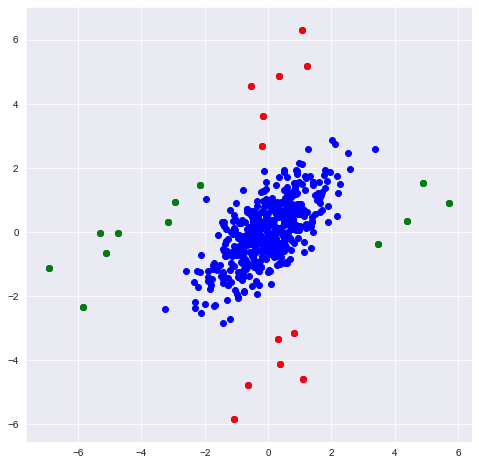

In [5]:
# create outliers and plot them
ANOMALIES_FAC = 0.05

samples, (rand_idx, rand_idx_x, rand_idx_y) = make_outliers(samples, ANOMALIES_FAC)

plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = samples[rand_idx_y, 0], y = samples[rand_idx_y, 1], c="r")
plt.scatter(x = samples[rand_idx_x, 0], y = samples[rand_idx_x, 1], c="g")
plt.show()

### Fit GMM
This fits a GMM to the data estimates the outliers by giving the outlier score as the inverse of the log likelihood given by the GMM. <br>
Also it plots the ROC Curve to get and overview how well the model predicts the outlers and plots the learned components of the GMM to see if it fits the data. 

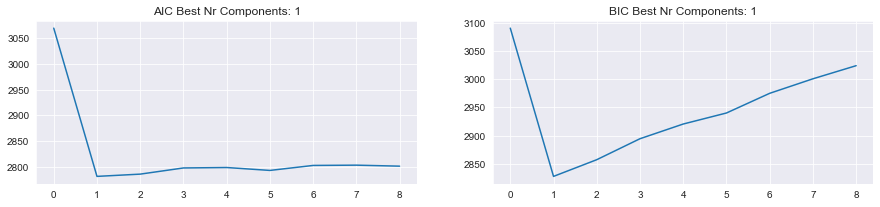

In [6]:

aic = []

bic = []

for c in range(1, 10):
    gmm = GaussianMixture(n_components=c, random_state=0).fit(samples)
    aic.append(gmm.aic(samples))
    bic.append(gmm.bic(samples))

    
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].plot(aic)
axes[0].set_title("AIC Best Nr Components: {}".format(np.argmin(np.array(aic))))

axes[1].plot(bic)
axes[1].set_title("BIC Best Nr Components: {}".format(np.argmin(np.array(bic))))
plt.show()

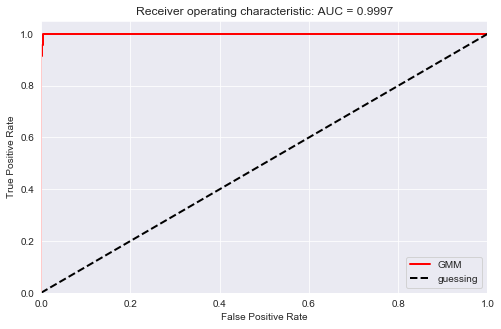

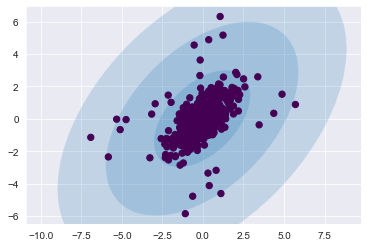

,f1,f2,score,label
369,-6.921023,-1.142628,20.858122,1.0
304,1.060484,6.314499,17.614367,1.0
427,-1.088591,-5.852330,15.477458,1.0
415,5.706042,0.883730,15.431324,1.0
83,-5.324342,-0.023277,14.757485,1.0


In [7]:
N_COMPONENTS = 1

gmm = GaussianMixture(n_components=N_COMPONENTS, random_state=SEED).fit(samples)
gmm_log_scores = gmm.score_samples(samples)
gmm_exp_scores = np.exp(gmm_log_scores)

scored_df = pd.DataFrame(samples)
scored_df.reset_index()
scored_df.columns = ["f1", "f2"]
scored_df["score"] = gmm_log_scores * -1
labels = np.zeros(samples_size)
labels[rand_idx] = 1
scored_df["label"] = labels


fpr, tpr, thresholds = metrics.roc_curve(scored_df['label'], scored_df['score'], pos_label=1)
auc = metrics.auc(fpr,tpr)

plt.figure(figsize=[8,5])
plt.plot(fpr, tpr, color='r', lw=2, label='GMM')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC = {0:0.4f}'.format(auc))
plt.legend(loc="lower right")
plt.show()


sorted_df = scored_df.sort_values(by="score", ascending=False)
plot_gmm(gmm, samples)
sorted_df.head(5)

Seems like the GMM fitted the data good enough to detect nearly all outliers. 
Also with 2 components the GMM learned one component with a small variance a high weight for the inliners and component with a large variance and low weight which also covers the outliers. 

### Outlier Explainability

The idea is now to use the leraned components of the GMM to derive an explanation why certain points are detected as outliers. Two approaches will be used:

1. Mahalanobis Distance per Dimension: <br>
Calculate the mahalanobis distance per dimension to each cluster to see which dimension may cause the outlier. The distance is given by:
$$d\left(\vec{x}, \vec{y}\right) = \sqrt{|\left(\vec{x}-\vec{y}\right)^\top S^{-1} \circ \left(\vec{x}-\vec{y}\right) |}$$

2. Conditional Distribution per Dimension (see https://peterroelants.github.io/posts/multivariate-normal-primer/): <br>
The conditional distribution of x given y is defined as:

$$p(\mathbf{x} \mid \mathbf{y}) = \mathcal{N}(\mu_{x|y}, \Sigma_{x|y})$$
    With:
$$\begin{split}
\Sigma_{x|y} & = A - CB^{-1}C^\top = \tilde{A}^{-1} \\
\mu_{x|y} & = \mu_x + CB^{-1}(\mathbf{y}-\mu_y)
\end{split}$$


In [8]:
def mah_dist_per_dimension(means, covs, l, X):
    """calculates the mahalanobis distance per dimension"""
    cov = covs[l]
    mean = means[l]
    cov_inv = np.linalg.inv(cov)
    x_m = X - mean
    tmp = np.matmul(x_m, cov_inv)
    mah_d = np.multiply(tmp, x_m.T)
    return np.sqrt(np.abs(mah_d))

def univariate_normal(x, mean, variance):
    """pdf of the univariate normal distribution"""
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution"""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [9]:
def plot_mah_dist(mah_dist, weights):
    labels = ["C: {} -- w: {:.03f}".format(idx, w) for idx, w in enumerate(weights)]
    mah_x = mah_dist[:,0]
    mah_y = mah_dist[:,1]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(20, 5))
    rects1 = ax.bar(x - width/2, mah_x, width, label='X')
    rects2 = ax.bar(x + width/2, mah_y, width, label='Y')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontdict={"fontsize":20})

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Maha Distance')
    ax.set_title('Maha Distance by Componennt and Dimension')
    ax.legend()

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)
    #ax.set_yscale('log')

    fig.tight_layout()

    plt.show()
 


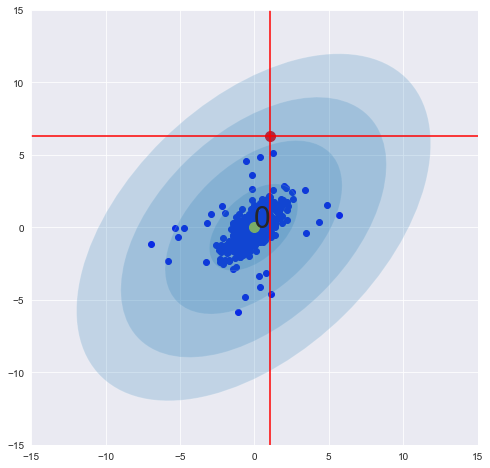

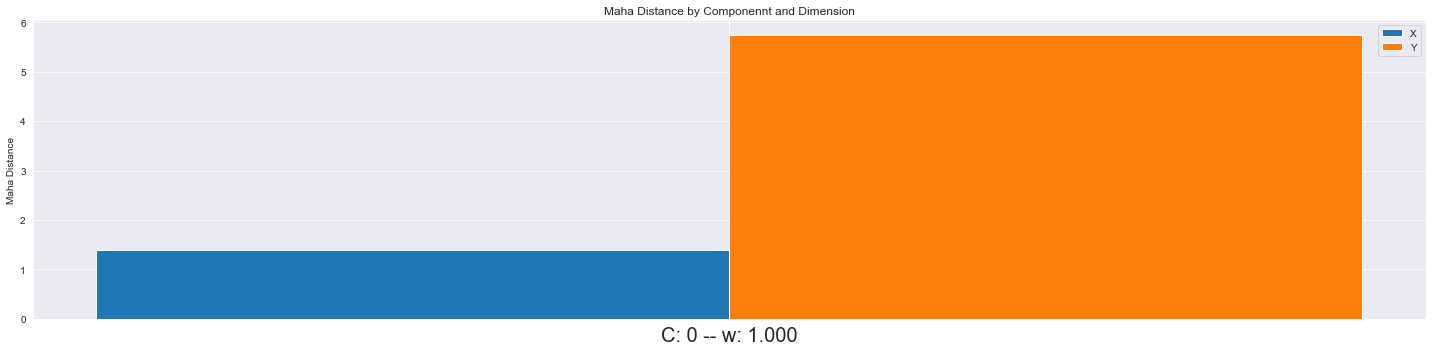

In [10]:
TOP_X_OUTLIER = 0
TOP_X_OUTLIER = 1

top_anomalies_idx = sorted_df.index.values
anomaly_idx = top_anomalies_idx[TOP_X_OUTLIER]
d = samples[anomaly_idx]
mah_dist = [mah_dist_per_dimension(gmm.means_, gmm.covariances_, c, d) for c in range(len(gmm.weights_))]
plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = d[0], y = d[1], c="r", s=100)
plt.axvline(x=d[0], c="r")
plt.axhline(y=d[1], c="r")

plt.xlim(-15, 15)
plt.ylim(-15, 15)

max_mah = np.max(mah_dist)

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor, nr_patches=5)


for idx, c in enumerate(gmm.means_):
    plt.scatter(x=c[0], y=c[1], c="yellow", s=100)
    plt.text(c[0], c[1], idx, size=30)

plot_mah_dist(np.array(mah_dist), gmm.weights_)

## Blobs Clusters
### Generate Synthetic Data
This creates three synthetic two dimensional data clusters and introduces outliers in x, y or in both dimensions.

In [11]:
from sklearn.datasets import make_blobs

In [12]:
X, y = make_blobs(n_samples=[200, 200, 100], centers=None, center_box=(-5, 5), random_state=SEED, cluster_std=[0.8, 0.6, 0.3])
samples = X
samples.shape

(500, 2)

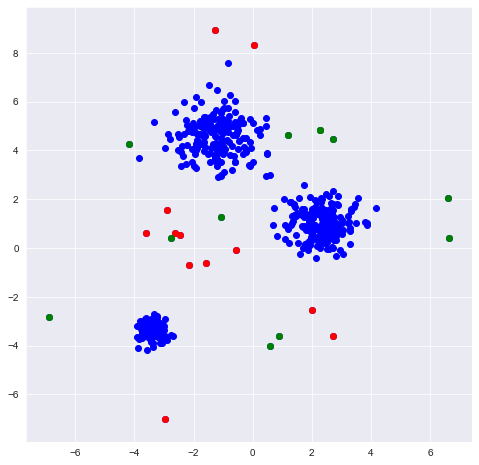

In [13]:
# create outliers and plot them
ANOMALIES_FAC = 0.05

samples, (rand_idx, rand_idx_x, rand_idx_y) = make_outliers(samples, ANOMALIES_FAC)

plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = samples[rand_idx_y, 0], y = samples[rand_idx_y, 1], c="r")
plt.scatter(x = samples[rand_idx_x, 0], y = samples[rand_idx_x, 1], c="g")
plt.show()

### Fit the Model

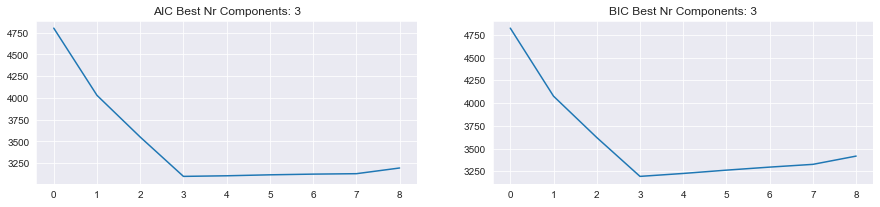

In [14]:

aic = []

bic = []

for c in range(1, 10):
    gmm = GaussianMixture(n_components=c, random_state=0).fit(samples)
    aic.append(gmm.aic(samples))
    bic.append(gmm.bic(samples))

    
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].plot(aic)
axes[0].set_title("AIC Best Nr Components: {}".format(np.argmin(np.array(aic))))

axes[1].plot(bic)
axes[1].set_title("BIC Best Nr Components: {}".format(np.argmin(np.array(bic))))
plt.show()

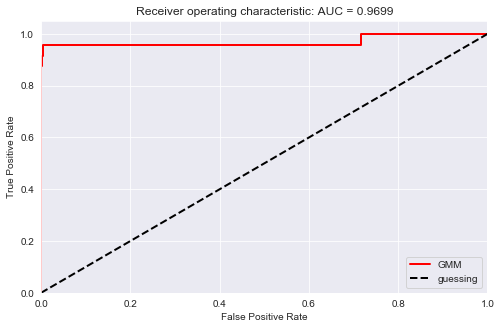

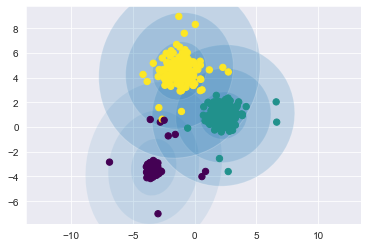

,f1,f2,score,label
363,2.712559,-3.598766,20.135844,1.0
104,0.878092,-3.590671,19.417793,1.0
65,6.593236,2.037947,18.395917,1.0
227,6.634875,0.399561,18.317589,1.0
95,0.585161,-4.006917,17.887864,1.0


In [15]:
N_COMPONENTS = 3

gmm = GaussianMixture(n_components=N_COMPONENTS, random_state=SEED).fit(samples)
# calculate the n nearest neighbors for the given dataset
gmm_log_scores = gmm.score_samples(samples)
gmm_exp_scores = np.exp(gmm_log_scores)
# calculate the global knn gy caluclating the avg and exluding the first one

scored_df = pd.DataFrame(samples)
scored_df.reset_index()
scored_df.columns = ["f1", "f2"]
scored_df["score"] = gmm_log_scores * -1
labels = np.zeros(samples_size)
labels[rand_idx] = 1
scored_df["label"] = labels


fpr, tpr, thresholds = metrics.roc_curve(scored_df['label'], scored_df['score'], pos_label=1)
auc = metrics.auc(fpr,tpr)

plt.figure(figsize=[8,5])
plt.plot(fpr, tpr, color='r', lw=2, label='GMM')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC = {0:0.4f}'.format(auc))
plt.legend(loc="lower right")
plt.show()


sorted_df = scored_df.sort_values(by="score", ascending=False)
plot_gmm(gmm, samples)
sorted_df.head(5)

### Outlier Explainability

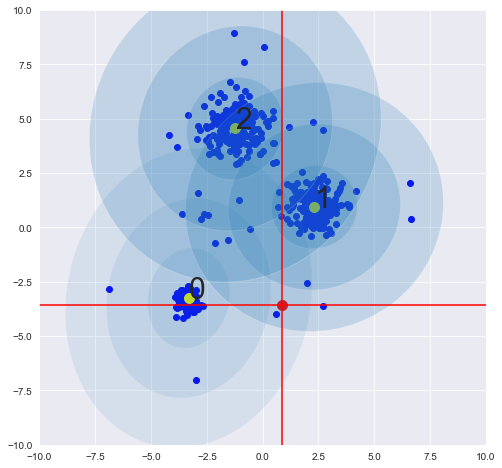

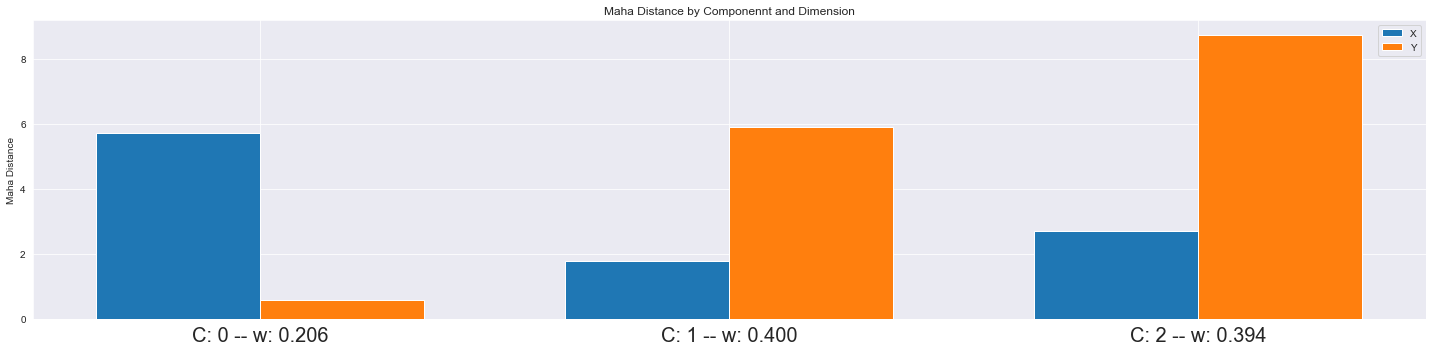

In [16]:
TOP_X_OUTLIER = 1
#TOP_X_OUTLIER = 2
#TOP_X_OUTLIER = 12

top_anomalies_idx = sorted_df.index.values
anomaly_idx = top_anomalies_idx[TOP_X_OUTLIER]
d = samples[anomaly_idx]
mah_dist = [mah_dist_per_dimension(gmm.means_, gmm.covariances_, c, d)  for c in range(len(gmm.weights_))]
plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = d[0], y = d[1], c="r", s=100)
plt.axvline(x=d[0], c="r")
plt.axhline(y=d[1], c="r")


plt.xlim(-10, 10)
plt.ylim(-10, 10)

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)

for idx, c in enumerate(gmm.means_):
    plt.scatter(x=c[0], y=c[1], c="yellow", s=100)
    plt.text(c[0], c[1], idx, size=30)
    
plot_mah_dist(np.array(mah_dist), gmm.weights_)

## Miltiple Guassian

### Generate Synthetic Data
This creates synthetic data based on three two dimensional normal distributions and introduces outliers in x, y or in both dimensions.

In [17]:
X, y = make_blobs(n_samples=samples_size, random_state=SEED)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
samples = X_aniso
samples.shape

(500, 2)

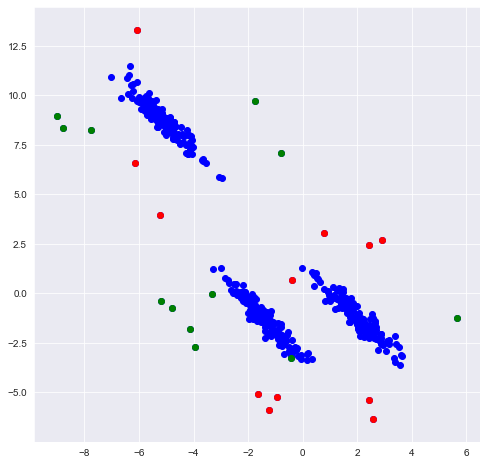

In [18]:
anomalies_fac = 0.05

samples, (rand_idx, rand_idx_x, rand_idx_y) = make_outliers(samples, anomalies_fac)

plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = samples[rand_idx_y, 0], y = samples[rand_idx_y, 1], c="r")
plt.scatter(x = samples[rand_idx_x, 0], y = samples[rand_idx_x, 1], c="g")
#plt.xlim([-10, 10])
#plt.ylim([-10, 10])

### Fit the Model

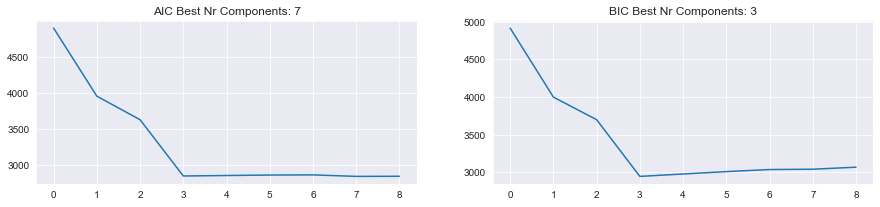

In [19]:

aic = []

bic = []

for c in range(1, 10):
    gmm = GaussianMixture(n_components=c, random_state=0).fit(samples)
    aic.append(gmm.aic(samples))
    bic.append(gmm.bic(samples))

    
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].plot(aic)
axes[0].set_title("AIC Best Nr Components: {}".format(np.argmin(np.array(aic))))

axes[1].plot(bic)
axes[1].set_title("BIC Best Nr Components: {}".format(np.argmin(np.array(bic))))
plt.show()

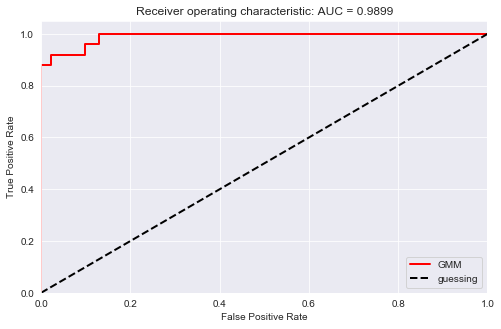

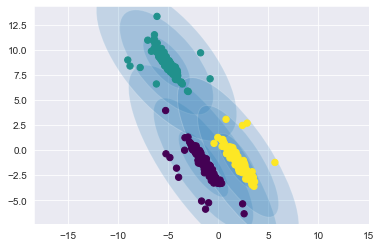

,f1,f2,score,label
373,5.658928,-1.233049,26.195882,1.0
360,2.889994,2.684990,24.734371,1.0
106,-1.747764,9.689808,18.829564,1.0
265,2.422121,2.456638,18.176574,1.0
120,-8.775852,8.374742,17.684308,1.0


In [20]:
N_COMPONENTS = 3

gmm = GaussianMixture(n_components=N_COMPONENTS, random_state=SEED).fit(samples)
# calculate the n nearest neighbors for the given dataset
gmm_log_scores = gmm.score_samples(samples)
gmm_exp_scores = np.exp(gmm_log_scores)
# calculate the global knn gy caluclating the avg and exluding the first one

scored_df = pd.DataFrame(samples)
scored_df.reset_index()
scored_df.columns = ["f1", "f2"]
scored_df["score"] = gmm_log_scores * -1
labels = np.zeros(samples_size)
labels[rand_idx] = 1
scored_df["label"] = labels


fpr, tpr, thresholds = metrics.roc_curve(scored_df['label'], scored_df['score'], pos_label=1)
auc = metrics.auc(fpr,tpr)

plt.figure(figsize=[8,5])
plt.plot(fpr, tpr, color='r', lw=2, label='GMM')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC = {0:0.4f}'.format(auc))
plt.legend(loc="lower right")
plt.show()


sorted_df = scored_df.sort_values(by="score", ascending=False)
plot_gmm(gmm, samples)
sorted_df.head(5)

### Outlier Explainability

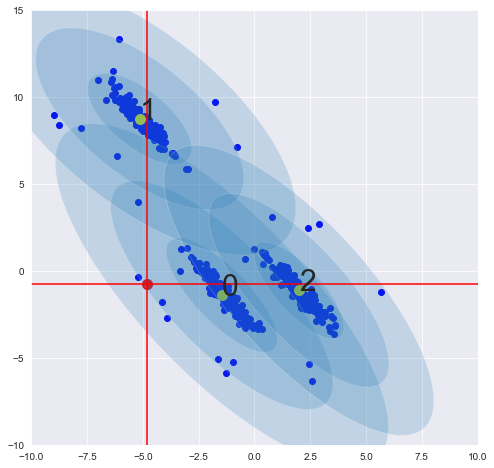

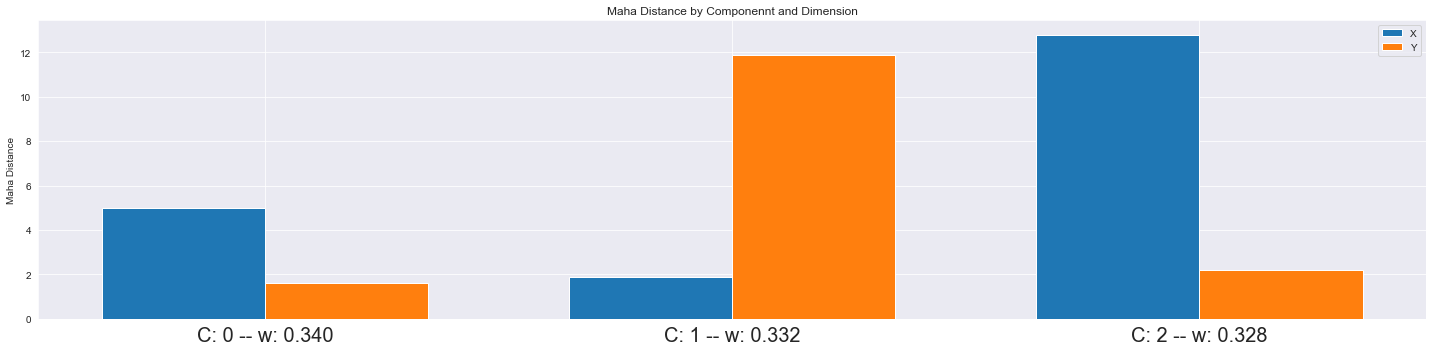

In [21]:
TOP_X_OUTLIER = 0
TOP_X_OUTLIER = 11

top_anomalies_idx = sorted_df.index.values
anomaly_idx = top_anomalies_idx[TOP_X_OUTLIER]
d = samples[anomaly_idx]
mah_dist = [mah_dist_per_dimension(gmm.means_, gmm.covariances_, c, d) for c in range(len(gmm.weights_))]
plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = d[0], y = d[1], c="r", s=100)
plt.axvline(x=d[0], c="r")
plt.axhline(y=d[1], c="r")


plt.xlim(-10, 10)
plt.ylim(-10, 15)

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)

for idx, c in enumerate(gmm.means_):
    plt.scatter(x=c[0], y=c[1], c="yellow", s=100)
    plt.text(c[0], c[1], idx, size=30)
    
plot_mah_dist(np.array(mah_dist), gmm.weights_)

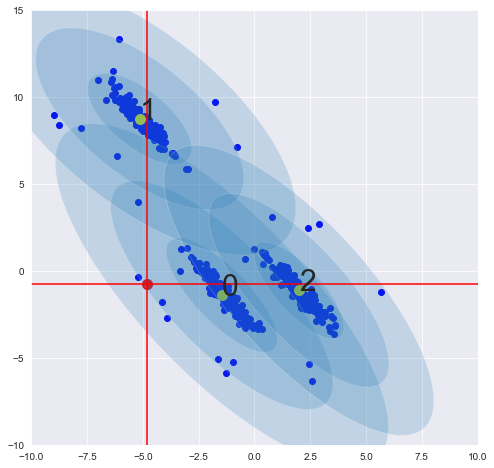

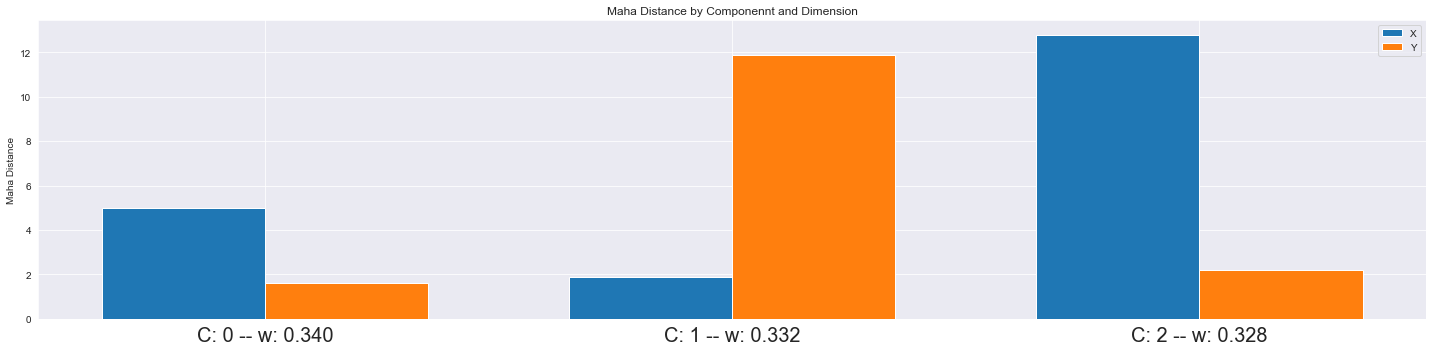

In [22]:
TOP_X_OUTLIER = 0
TOP_X_OUTLIER = 11

top_anomalies_idx = sorted_df.index.values
anomaly_idx = top_anomalies_idx[TOP_X_OUTLIER]
d = samples[anomaly_idx]
mah_dist = [mah_dist_per_dimension(gmm.means_, gmm.covariances_, c, d) for c in range(len(gmm.weights_))]
plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = d[0], y = d[1], c="r", s=100)
plt.axvline(x=d[0], c="r")
plt.axhline(y=d[1], c="r")


plt.xlim(-10, 10)
plt.ylim(-10, 15)

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)

for idx, c in enumerate(gmm.means_):
    plt.scatter(x=c[0], y=c[1], c="yellow", s=100)
    plt.text(c[0], c[1], idx, size=30)
    
plot_mah_dist(np.array(mah_dist), gmm.weights_)